In [2]:
import pandas as pd
from scipy import stats
from pylab import rcParams
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import seaborn as sns

### Download dataset 1) MutSpec of vertebrates; 2) asymmetry in nuclear genome; 3) Human Global Tree MutSpec with T nad R

In [3]:
assymetry = pd.read_table('../data/external/T-R_plot_allCpG.txt', sep=' ', header=None)
mut_vert = pd.read_csv('../data/MutSpecALLvert.csv')

In [4]:
mut_vert['MutBase'] = mut_vert.Mut.str.slice(2,5)
mut_vert['AncestorCodon'] = mut_vert.Mut.str.get(0) + mut_vert.Mut.str.get(2) + mut_vert.Mut.str.get(-1)
mut_vert.head()

,Mut,MutSpec,MutBase,AncestorCodon
0,A[A>C]A,0.000424,A>C,AAA
1,A[A>C]C,0.001497,A>C,AAC
2,A[A>C]G,0.000197,A>C,AAG
3,A[A>C]T,0.000000,A>C,AAT
4,A[A>G]A,0.014522,A>G,AAA


In [5]:
assymetry = assymetry.rename(columns={0:'AncestorCodon', 1:'MutBase', 2:'T', 3:'R'})
assymetry.head()

,AncestorCodon,MutBase,T,R
0,ACA,C>A,-0.171181,-0.373510
1,ACA,C>G,0.065067,0.034147
2,ACA,C>T,-0.012015,-0.052744
3,ACC,C>A,-0.091167,-0.285840
4,ACC,C>G,0.091991,0.144789


### Translate 192 mtDNA mutspec to 96 component

In [6]:
def gettranslate(mut, reverse=True):
    translator = str.maketrans("ACGT", "TGCA")
    if reverse is True:
        mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = mut.translate(translator)
    return new_mut

In [7]:
def transform192_to96(asymmetry_df, df_transform):
    to_96_comp = []
    for num_subs in range(0,96):
        # define ancestral and mutbase from mutspec according on 96 comp from asymmetry
        anc = asymmetry_df.iloc[num_subs, 0]
        mb = asymmetry_df.iloc[num_subs, 1]
        # get reverse subs with context
        rev_anc = gettranslate(anc, reverse=True)
        rev_mb = gettranslate(mb, reverse=False)
        # find mutspec num for the mutbase and context same with reverse, than devide on reverse
        rev_mutspec = df_transform[(df_transform.MutBase == rev_mb) & (df_transform.AncestorCodon == rev_anc)].MutSpec.values[0]
        mutspec = df_transform[(df_transform.MutBase == mb) & (df_transform.AncestorCodon == anc)].MutSpec.values[0]
        new_96_mut = mutspec/rev_mutspec
        #define row for future df
        out_mut = {'AncestorCodon': anc, 'MutBase': mb, 'MutSpec': new_96_mut}
        to_96_comp.append(out_mut)

    mut_96_comp = pd.DataFrame(to_96_comp)
    mut_96_comp["MutSpec"] = mut_96_comp["MutSpec"].replace(np.inf, 0)
    mut_96_comp["MutSpec"] = mut_96_comp["MutSpec"].fillna(0)
    return(mut_96_comp)
    

In [8]:
mut_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=mut_vert)
mut_96_comp.head()

/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_75317/1000977383.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_75317/1000977383.py:13: RuntimeWarning: invalid value encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec


,AncestorCodon,MutBase,MutSpec
0,ACA,C>A,0.000000
1,ACA,C>G,0.000000
2,ACA,C>T,3.473528
3,ACC,C>A,0.000000
4,ACC,C>G,0.000000


In [9]:
final_asymmetry = assymetry.merge(right = mut_96_comp, on=['AncestorCodon', 'MutBase'])
final_asymmetry = final_asymmetry[final_asymmetry.MutSpec != 0]
final_asymmetry.MutSpec = np.log2(final_asymmetry.MutSpec)
final_asymmetry.head()

,AncestorCodon,MutBase,T,R,MutSpec
2,ACA,C>T,-0.012015,-0.052744,1.796402
5,ACC,C>T,0.028556,-0.069531,2.329356
8,ACG,C>T,0.071747,0.012317,1.465678
11,ACT,C>T,-0.088058,-0.074512,1.504908
13,ATA,T>C,-0.320754,-0.774055,-2.192291


### What is the per for C>T symmetry part and all TV

In [10]:
TV_vec = ['A>T', 'T>A', 'C>G', 'G>C', 'C>A', 'A>C', 'T>G', 'G>T']

In [11]:
print(f"Sum of symmetrycal part of C>T plus all trasversions is {sum(mut_vert[mut_vert.MutBase.isin(TV_vec)].MutSpec.values) + sum(mut_vert[mut_vert.MutBase == 'G>A'].MutSpec.values) * 2}")

Sum of symmetrycal part of C>T plus all trasversions is 0.38759734569276594


In [12]:
sum(mut_vert[mut_vert.MutBase.isin(TV_vec)].MutSpec.values)

0.13141465503655336

In [13]:
sum(mut_vert[mut_vert.MutBase == 'G>A'].MutSpec.values) * 2

0.2561826906562126

### Define C>T and A>G asymmetry from all mutations in mutspec

C>T

In [14]:
mut_vert.head()

,Mut,MutSpec,MutBase,AncestorCodon
0,A[A>C]A,0.000424,A>C,AAA
1,A[A>C]C,0.001497,A>C,AAC
2,A[A>C]G,0.000197,A>C,AAG
3,A[A>C]T,0.000000,A>C,AAT
4,A[A>G]A,0.014522,A>G,AAA


In [15]:
asymmetry_CT_val = 0
for mut in mut_vert[mut_vert.MutBase == 'C>T'].Mut.values:
    CT_val = mut_vert[mut_vert.Mut == mut].MutSpec.values[0]
    rev_mut = gettranslate(mut)
    GA_val = mut_vert[mut_vert.Mut == rev_mut].MutSpec.values[0]
    asymmetry_CT_val += (CT_val - GA_val)

asymmetry_CT_val / sum(mut_vert.MutSpec.values)

0.291899908031728

Now A>G

In [16]:
asymmetry_AG_val = 0
for mut in mut_vert[mut_vert.MutBase == 'A>G'].Mut.values:
    AG_val = mut_vert[mut_vert.Mut == mut].MutSpec.values[0]
    rev_mut = gettranslate(mut)
    TC_val = mut_vert[mut_vert.Mut == rev_mut].MutSpec.values[0]
    asymmetry_AG_val += (AG_val - TC_val)

asymmetry_AG_val / sum(mut_vert.MutSpec.values)

0.18621329056925945

### Complete cor test for t and r asymmetry and mtDNA mutSpec

In [17]:
t_cor = stats.spearmanr(final_asymmetry['T'].values, final_asymmetry.MutSpec.values, axis=0)
t_cor

SignificanceResult(statistic=0.6386990876817956, pvalue=4.618983340981669e-09)

In [18]:
r_cor = stats.spearmanr(final_asymmetry['R'].values, final_asymmetry.MutSpec.values)
r_cor

SignificanceResult(statistic=0.6245753330534031, pvalue=1.2563866833839332e-08)

### Draw plot for T and R asymmetry and mutspec

In [19]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

In [20]:
final_asymmetry = final_asymmetry.rename(columns={'MutBase':'Mutation Base'})

Text(0.5, 0.01, 'log2[mtDNA Mutational Spectrum Asymmetry]')

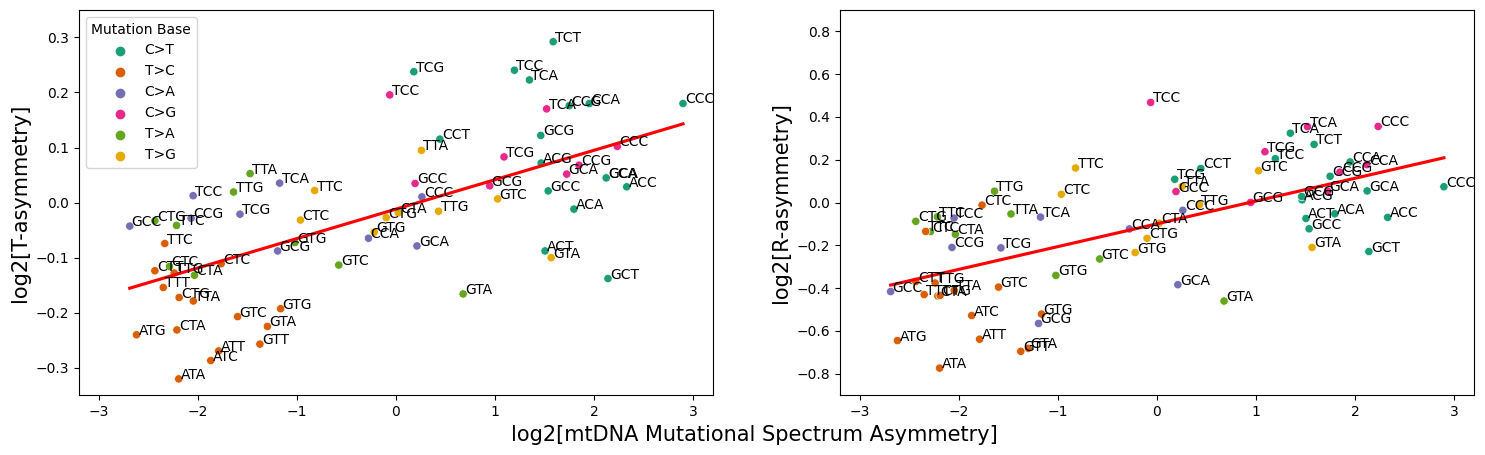

In [21]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(18,5))

sns.scatterplot(data = final_asymmetry, x='MutSpec', y='T', hue='Mutation Base', ax=axes[0], palette='Dark2')
label_point(final_asymmetry.MutSpec, final_asymmetry['T'], final_asymmetry.AncestorCodon, axes[0])
sns.regplot(data=final_asymmetry, x='MutSpec', y='T', ci=None, scatter=False,color='red', ax=axes[0])
#axes[0].legend([],[], frameon=False)
axes[0].set_xlim(-3.2,3.2)
axes[0].set_ylim(-0.35,0.35)
axes[0].set_xlabel('')
axes[0].set_ylabel('log2[T-asymmetry]', size=15)


sns.scatterplot(data = final_asymmetry, x='MutSpec', y='R', hue='Mutation Base', ax=axes[1], palette='Dark2')
label_point(final_asymmetry.MutSpec, final_asymmetry['R'], final_asymmetry.AncestorCodon, axes[1])
sns.regplot(data=final_asymmetry, x='MutSpec', y='R', ci=None, scatter=False,color='red', ax=axes[1])
axes[1].legend([],[], frameon=False)
axes[1].set_xlim(-3.2,3.2)
axes[1].set_ylim(-0.9,0.9)
axes[1].set_xlabel('')
axes[1].set_ylabel('log2[R-asymmetry]', size = 15)
fig.supxlabel('log2[mtDNA Mutational Spectrum Asymmetry]', size=15)
#fig.savefig('../pictures/AsymmetryTRM.pdf', dpi=300)

In [22]:
#final_asymmetry.to_csv('../data/asymmetry_mutspec.csv', index=False)

### Error bar for mtDNA MutSpec asymmetry

In [23]:
err_dt = final_asymmetry.groupby('Mutation Base').agg(
    T_mean = pd.NamedAgg(column='T', aggfunc='mean'),
    T_sd = pd.NamedAgg(column='T', aggfunc='std'),
    R_mean = pd.NamedAgg(column='R', aggfunc='mean'),
    R_sd = pd.NamedAgg(column='R', aggfunc='std'),
    mut_mean = pd.NamedAgg(column='MutSpec', aggfunc='mean'),
    mut_sd = pd.NamedAgg(column='MutSpec', aggfunc='std')).reset_index()

In [24]:
err_dt

,Mutation Base,T_mean,T_sd,R_mean,R_sd,mut_mean,mut_sd
0,C>A,-0.029671,0.043175,-0.232139,0.184167,-1.171815,1.048685
1,C>G,0.086727,0.059437,0.204274,0.161479,1.290310,0.815506
2,C>T,0.105891,0.123658,0.062509,0.149783,1.606742,0.662963
3,T>A,-0.067207,0.072658,-0.167339,0.159896,-1.443938,1.006378
4,T>C,-0.198624,0.069060,-0.468007,0.201173,-1.966376,0.433882
5,T>G,-0.013905,0.053733,-0.032676,0.150795,0.133466,0.810865


In [25]:
# sort MutBase values as in scatter plot
err_dt['Mutation Base'] = pd.Categorical(err_dt['Mutation Base'], ['C>T', 'T>C', 'C>A', 'C>G', 'T>A', 'T>G'])
err_dt = err_dt.sort_values(['Mutation Base'])

In [26]:
err_dt

,Mutation Base,T_mean,T_sd,R_mean,R_sd,mut_mean,mut_sd
2,C>T,0.105891,0.123658,0.062509,0.149783,1.606742,0.662963
4,T>C,-0.198624,0.069060,-0.468007,0.201173,-1.966376,0.433882
0,C>A,-0.029671,0.043175,-0.232139,0.184167,-1.171815,1.048685
1,C>G,0.086727,0.059437,0.204274,0.161479,1.290310,0.815506
3,T>A,-0.067207,0.072658,-0.167339,0.159896,-1.443938,1.006378
5,T>G,-0.013905,0.053733,-0.032676,0.150795,0.133466,0.810865


Text(0.5, 0.01, 'log2[mtDNA Mutational Spectrum Asymmetry]')

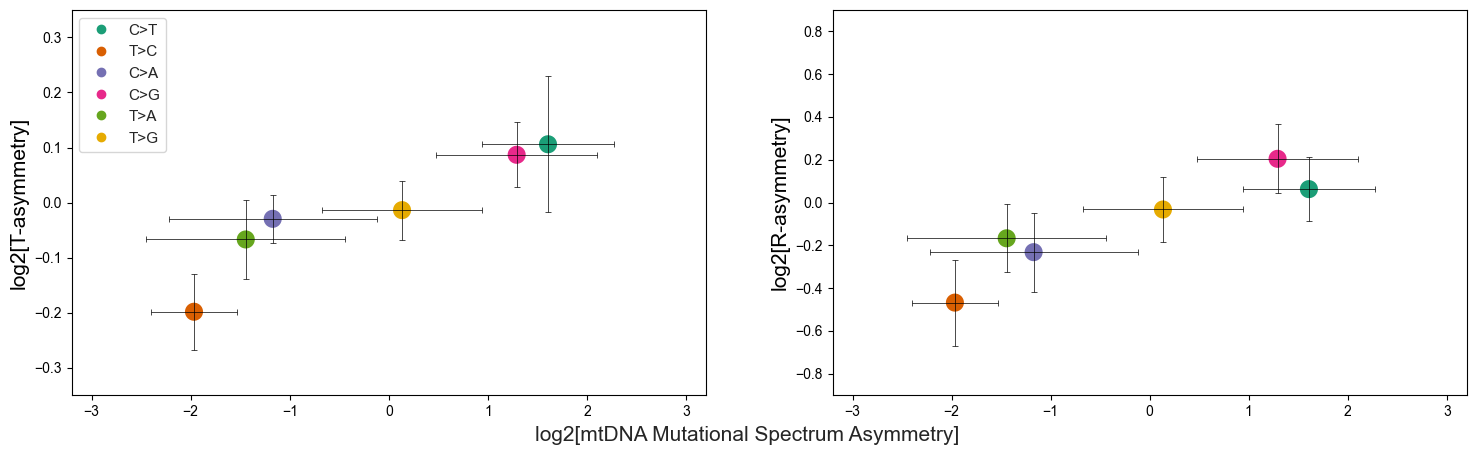

In [27]:
fig, axes = plt.subplots(1,2, sharex=False, figsize=(18,5))
sns.set_style("ticks")

sns.scatterplot(y="T_mean", x="mut_mean", data=err_dt, palette="Dark2", 
                hue='Mutation Base', s=200, ax=axes[0])
axes[0].errorbar(y="T_mean", x="mut_mean", xerr='mut_sd', yerr='T_sd', fmt='None', elinewidth=0.5, 
             data=err_dt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[0].tick_params(axis='x')
axes[0].legend(loc='upper left', scatteryoffsets=[0.55], frameon=True, fontsize=11, ncol=1)
axes[0].set_xlim(-3.2,3.2)
axes[0].set_ylim(-0.35,0.35)
axes[0].set_xlabel("")
axes[0].set_ylabel("log2[T-asymmetry]", fontsize=15)


sns.scatterplot(y="R_mean", x="mut_mean", data=err_dt, palette="Dark2", 
                hue='Mutation Base', s=200, ax=axes[1])
axes[1].errorbar(y="R_mean", x="mut_mean", xerr='mut_sd', yerr='R_sd', fmt='None', elinewidth=0.5, 
             data=err_dt, label=None, capsize=2, capthick=0.5, ecolor='black')

axes[1].tick_params(axis='x')
axes[1].legend([],[], frameon=False)
axes[1].set_xlim(-3.2,3.2)
axes[1].set_ylim(-0.9,0.9)
axes[1].set_xlabel("")
axes[1].set_ylabel("log2[R-asymmetry]", fontsize=15)

fig.supxlabel('log2[mtDNA Mutational Spectrum Asymmetry]', size=15)
#fig.savefig("../pictures/AsymmetryErrorBars.pdf", dpi=300)

### Six types of base substitutions


In [28]:
bs_subs = ['C>A', 'T>A', 'C>G', 'T>C', 'C>T', 'T>G']

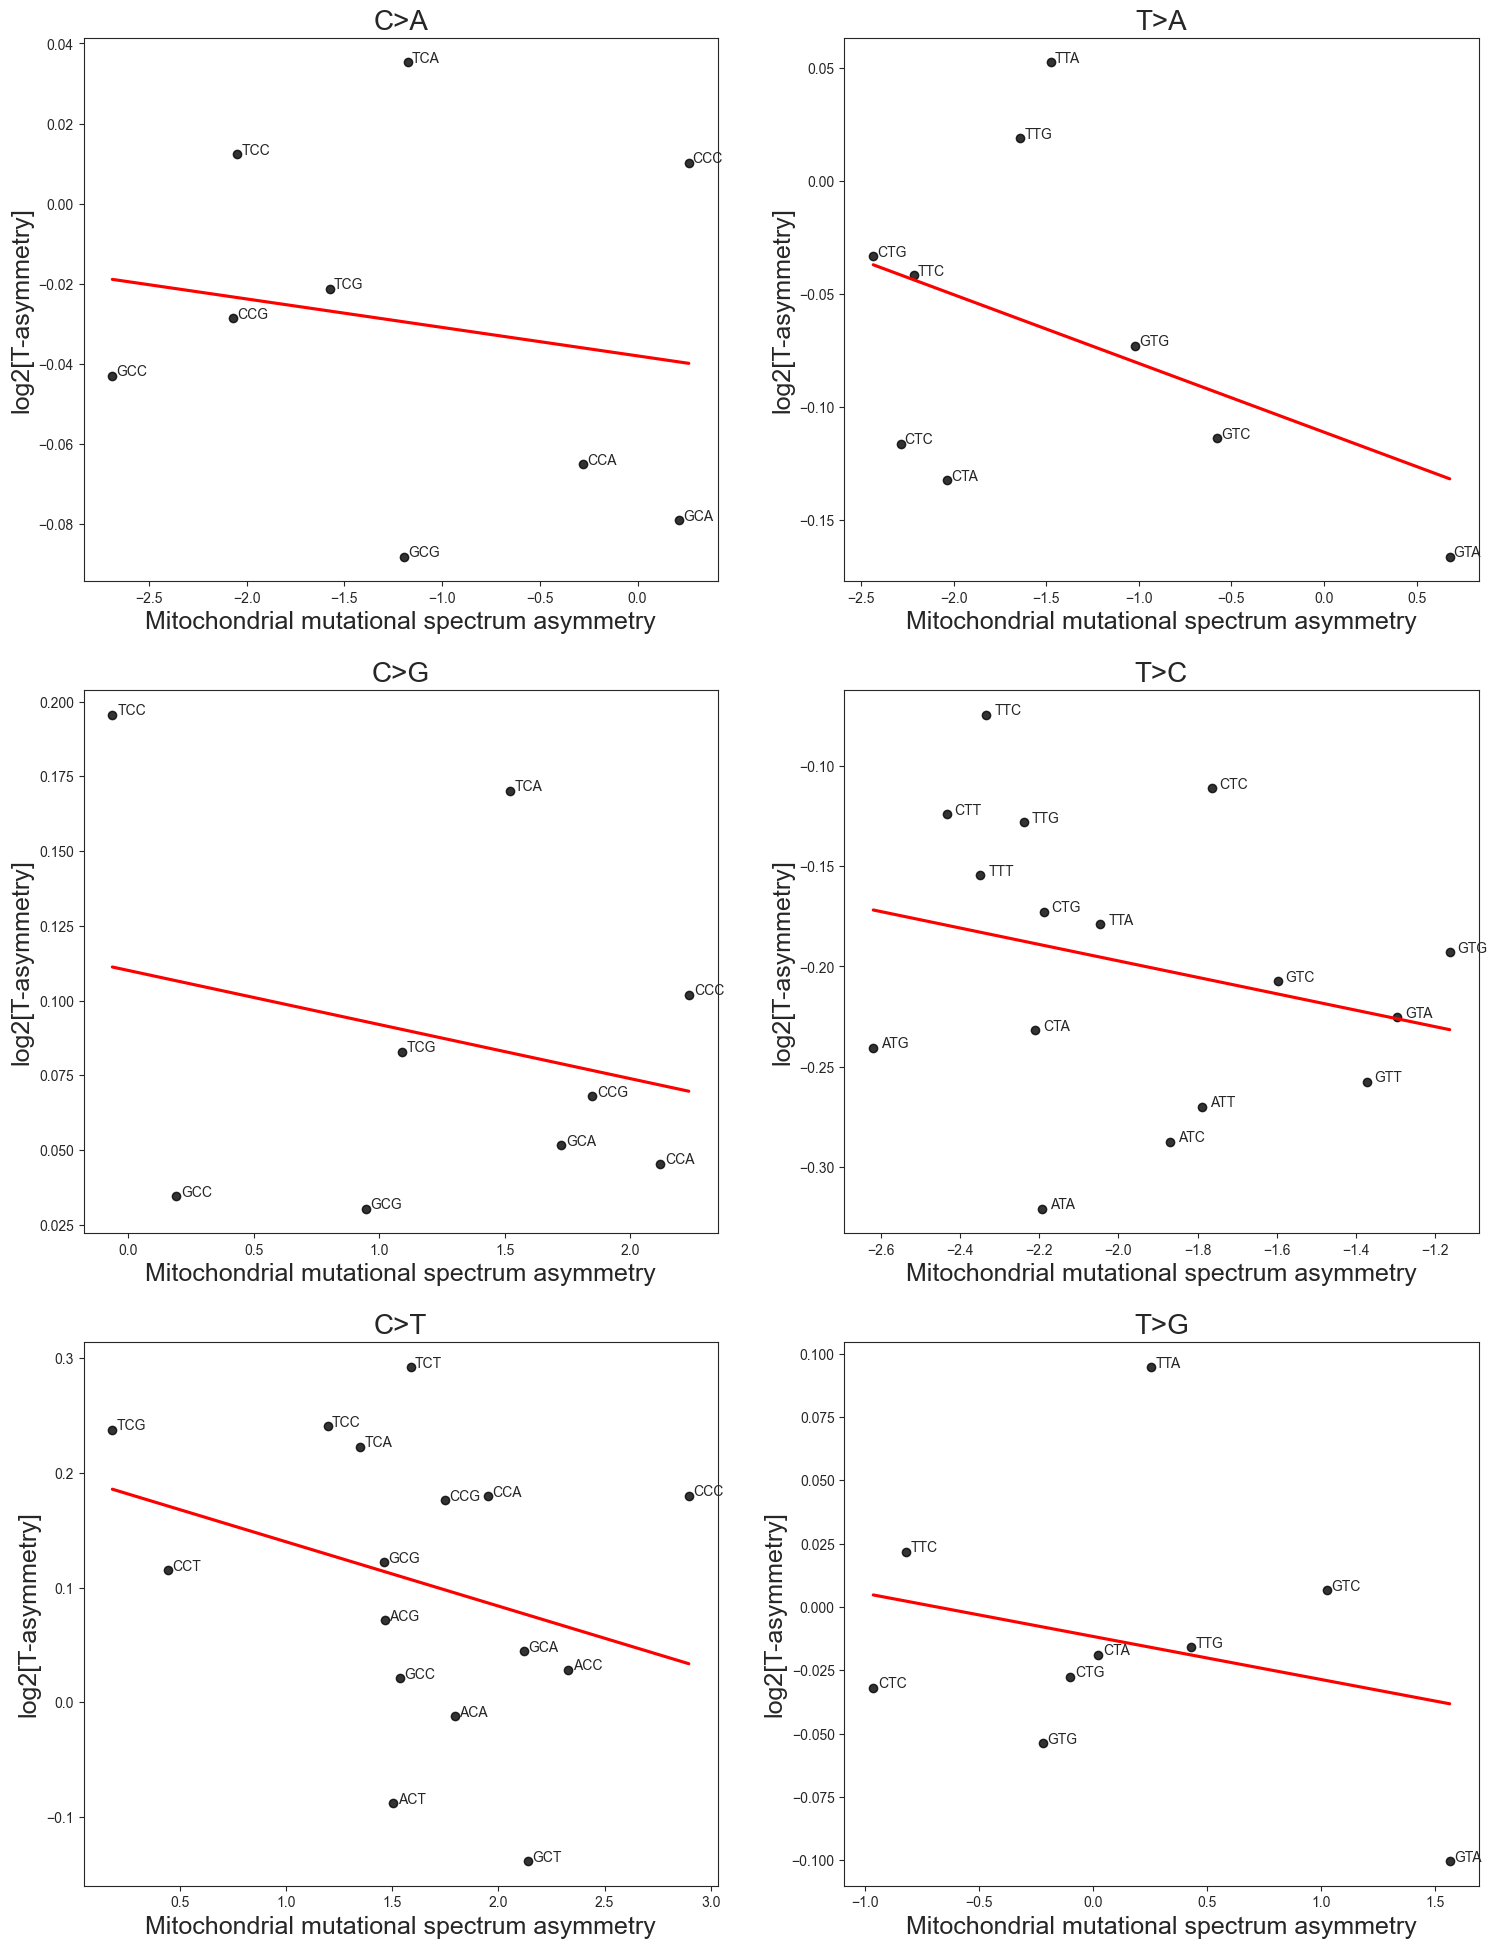

In [29]:
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18,24))

for sub, ax in zip(bs_subs, axes.ravel()):
    to_draw = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    sns.regplot(data = to_draw, x='MutSpec', y='T', ax=ax, ci=None, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"})
    label_point(to_draw.MutSpec, to_draw['T'], to_draw.AncestorCodon, ax)
    ax.set_title(sub, fontsize=20)
    ax.set_xlabel('Mitochondrial mutational spectrum asymmetry', fontsize=18)
    ax.set_ylabel('log2[T-asymmetry]', fontsize=18)
#fig.savefig('../pictures/AsymmetryMutBaseT.pdf', dpi=300)

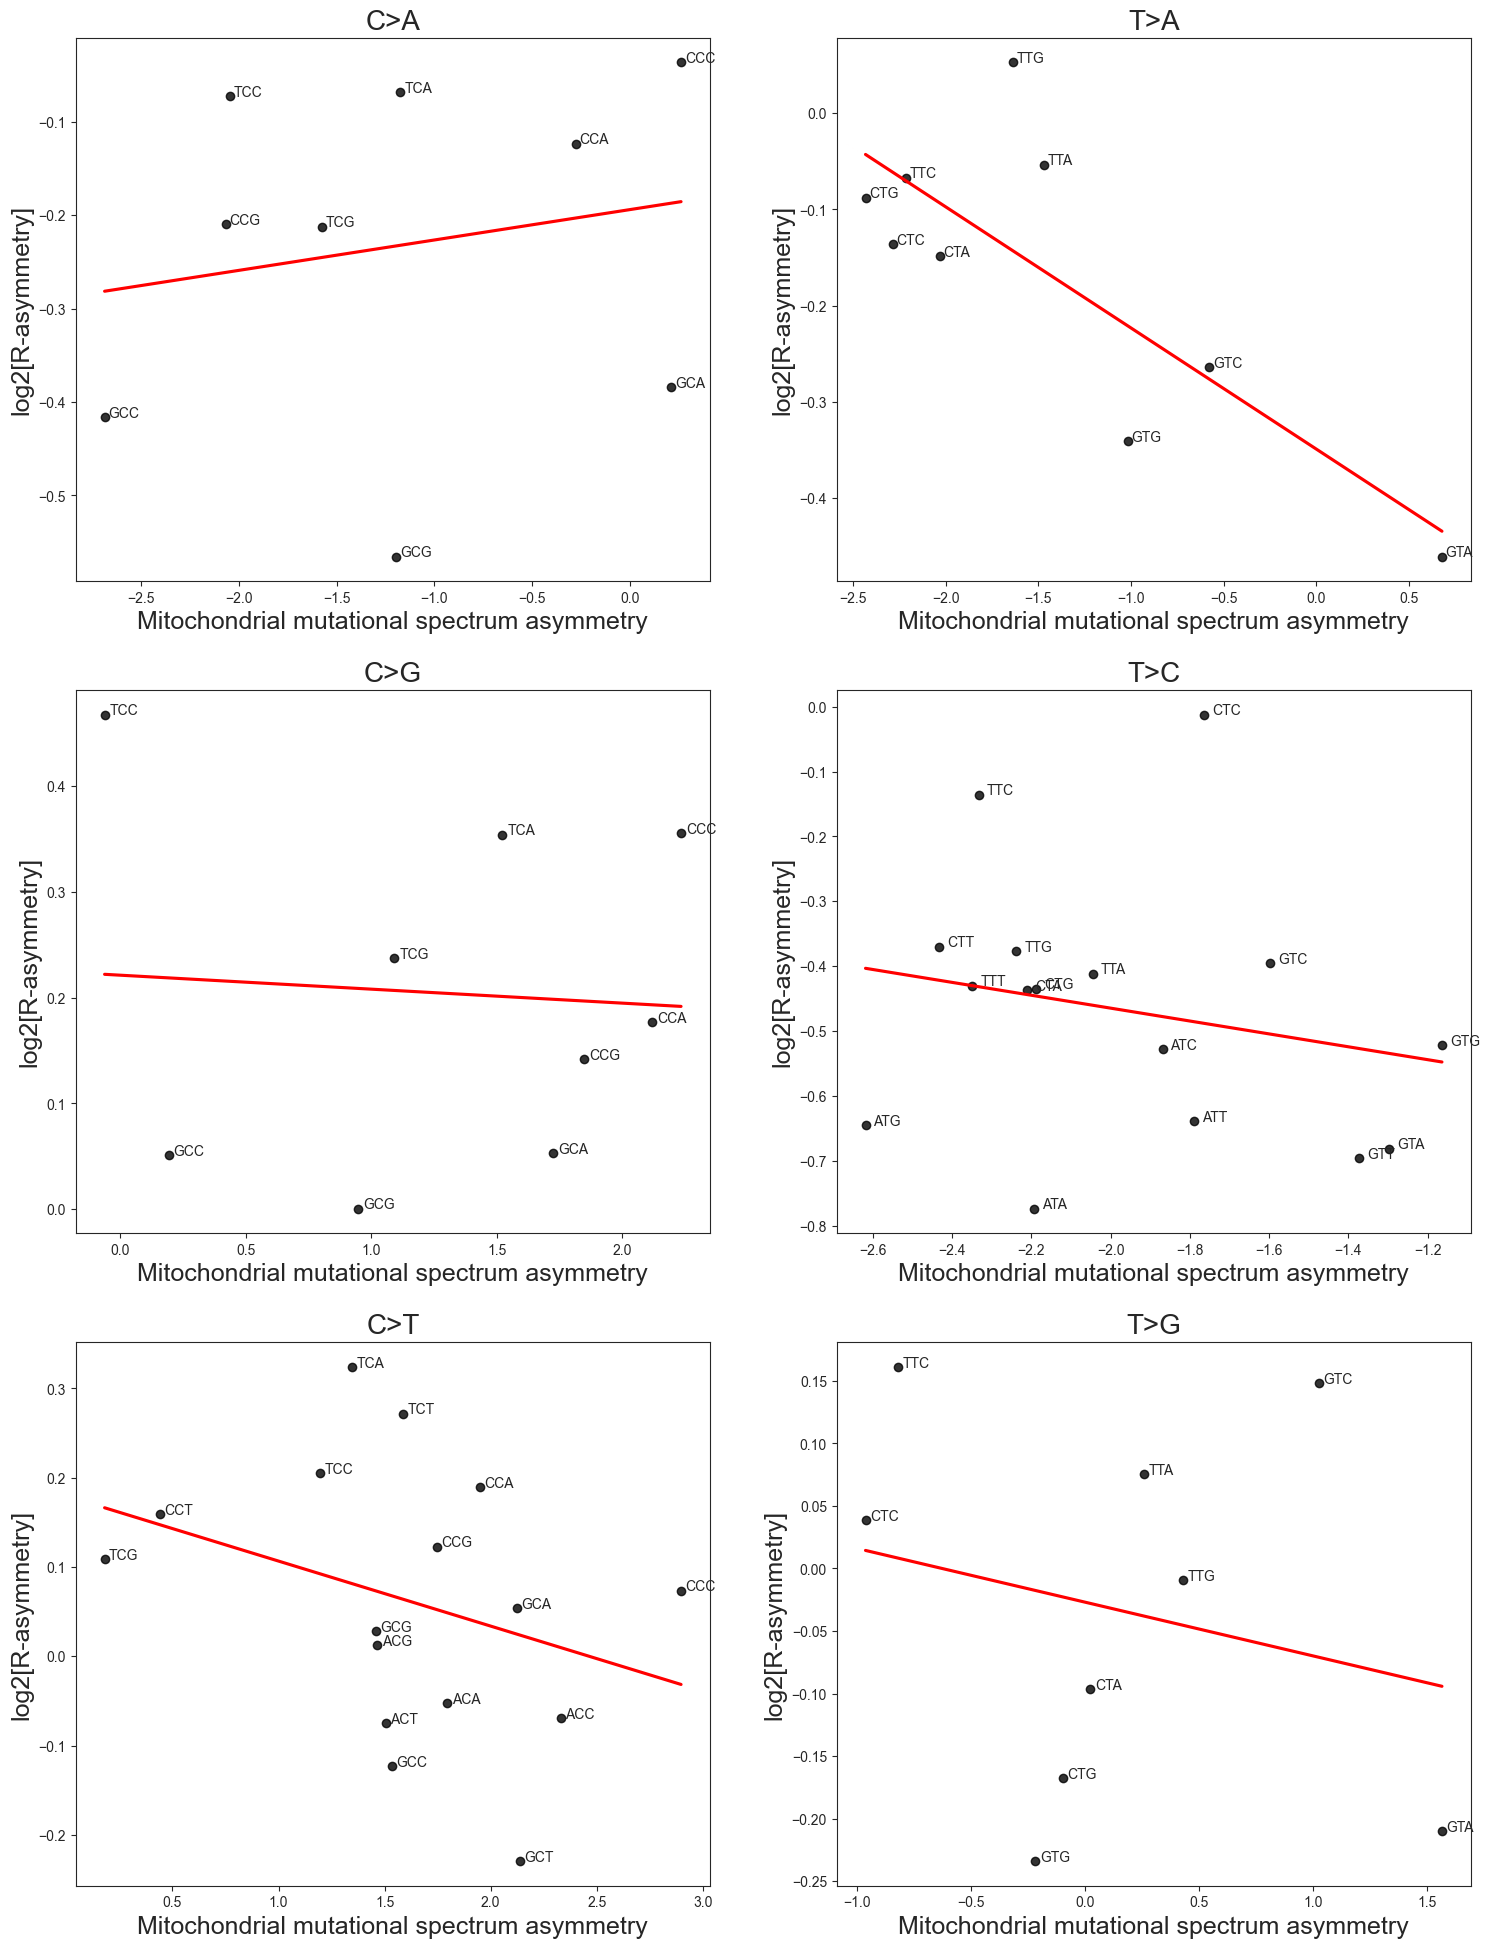

In [30]:
fig, axes = plt.subplots(3,2, sharex=False, figsize=(18,24))

for sub, ax in zip(bs_subs, axes.ravel()):
    to_draw = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    sns.regplot(data = to_draw, x='MutSpec', y='R', ax=ax, ci=None, 
                scatter_kws={"color": "black"}, line_kws={"color": "red"})
    label_point(to_draw.MutSpec, to_draw['R'], to_draw.AncestorCodon, ax)
    ax.set_title(sub, fontsize=20)
    ax.set_xlabel('Mitochondrial mutational spectrum asymmetry', fontsize=18)
    ax.set_ylabel('log2[R-asymmetry]', fontsize=18)
#fig.savefig('../pictures/AsymmetryMutBaseR.pdf', dpi=300)

### Made cor test with spearman for each combination of R/T and MutSpec

In [29]:
cor_res = []
for sub in bs_subs:
    to_cor = final_asymmetry[final_asymmetry['Mutation Base'] == sub]
    T_cor = stats.spearmanr(to_cor['T'].values, to_cor.MutSpec.values, axis=0)
    R_cor = stats.spearmanr(to_cor['R'].values, to_cor.MutSpec.values, axis=0)
    out_line = {'MutBase': sub, 'T_asymmetry_cor': T_cor.correlation, 'R_asymmetry_cor': R_cor.correlation}
    cor_res.append(out_line)
cor_res = pd.DataFrame(cor_res)
cor_res

,MutBase,T_asymmetry_cor,R_asymmetry_cor
0,C>A,-0.066667,0.400000
1,T>A,-0.266667,-0.533333
2,C>G,0.016667,0.133333
3,T>C,-0.279412,-0.279412
4,C>T,-0.376471,-0.382353
5,T>G,0.033333,-0.116667


### Damage analysis

In [30]:
main_subs = ['C>T', 'A>G', 'G>T', 'A>T', 'C>G', 'A>C']

In [31]:
damage = []
for mutbase in main_subs:
    cont_mb = mut_vert[mut_vert.MutBase == mutbase].Mut
    for context in cont_mb:
        mutspec_main = mut_vert[mut_vert.Mut == context].MutSpec.values[0]
        mutspec_rev = mut_vert[mut_vert.Mut == gettranslate(context, reverse=True)].MutSpec.values[0]
        out_damage = {'Mut':context,'ReverseMut':gettranslate(context, reverse=True), 'MutSpecDif':mutspec_main-mutspec_rev, 'MutBase': mutbase}
        damage.append(out_damage)
damage = pd.DataFrame(damage)
damage.head()

,Mut,ReverseMut,MutSpecDif,MutBase
0,A[C>T]A,T[G>A]T,0.024372,C>T
1,A[C>T]C,G[G>A]T,0.029733,C>T
2,A[C>T]G,C[G>A]T,0.015401,C>T
3,A[C>T]T,A[G>A]T,0.011718,C>T
4,C[C>T]A,T[G>A]G,0.025892,C>T


In [32]:
damage[damage.MutBase == 'C>T'].MutSpecDif.sum()

0.2918999080317257

In [33]:
damage.MutSpecDif.sum()

0.5245771260547207

## Linear models witn mtDNA asymmetry and HGT

### Linear model for mtDNA mutational spectrum of vertebrates

In [34]:
mtdna_reg = linear_model.LinearRegression()
mtdna_reg.fit(final_asymmetry[['T','R']].to_numpy(), final_asymmetry.MutSpec.to_numpy())
print('Coefficient for mtDNA model with T and R asymmetry', mtdna_reg.coef_)
print('Intercept:', mtdna_reg.intercept_)

Coefficient for mtDNA model with T and R asymmetry [4.88581761 1.44503543]
Intercept: 0.061236412936487405


# Cold versus Short comparison T and R asymmetry

### In our case cold is fish and warm is birds

### First, calculate a mutational spectrum for fishes and birds

In [36]:
mut_spec = pd.read_csv('../data/MutSpecVertebratescytb.csv')
mut_spec.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [37]:
def calc_mutspec_class(df: pd.DataFrame):
    ms_cls = df.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
    ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
    ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
    ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
    
    return ms_cls

In [38]:
fish_mut = calc_mutspec_class(mut_spec[mut_spec.Class == 'Actinopterygii'])
aves_mut = calc_mutspec_class(mut_spec[mut_spec.Class == 'Aves'])

### Transform our 192 comp mutspec of each class to 96 comp mutspec

In [39]:
fish_mut['MutBase'] = fish_mut.Mut.str.slice(2,5)
fish_mut['AncestorCodon'] = fish_mut.Mut.str.get(0) + fish_mut.Mut.str.get(2) + fish_mut.Mut.str.get(-1)
aves_mut['MutBase'] = aves_mut.Mut.str.slice(2,5)
aves_mut['AncestorCodon'] = aves_mut.Mut.str.get(0) + aves_mut.Mut.str.get(2) + aves_mut.Mut.str.get(-1)

In [40]:
fish_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=fish_mut)
aves_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=aves_mut)

/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_62453/1000977383.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_62453/1000977383.py:13: RuntimeWarning: invalid value encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_62453/1000977383.py:13: RuntimeWarning: invalid value encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_62453/1000977383.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec


### Delete subs with context that mutspec euqal 0 and log2 those mutspecs

In [41]:
fish_final = assymetry.merge(right = fish_96_comp, on=['AncestorCodon', 'MutBase'])
fish_final = fish_final[fish_final.MutSpec != 0]
fish_final.MutSpec = np.log2(fish_final.MutSpec)
fish_final['ColdWarm'] = 'Cold'

aves_final = assymetry.merge(right = aves_96_comp, on=['AncestorCodon', 'MutBase'])
aves_final = aves_final[aves_final.MutSpec != 0]
aves_final.MutSpec = np.log2(aves_final.MutSpec)
aves_final['ColdWarm'] = 'Warm'

cold_warm = pd.concat([aves_final, fish_final])
cold_warm['Mut'] = cold_warm.AncestorCodon.str.get(0) + '[' + cold_warm.MutBase.str.get(0) + '>'  + cold_warm.MutBase.str.get(-1) + ']' + cold_warm.AncestorCodon.str.get(-1)
cold_warm = cold_warm.rename(columns={'ColdWarm':'Temperature', 'MutSpec':'mtDNA Mutational Spectrum'})
cold_warm.head()

,AncestorCodon,MutBase,T,R,mtDNA Mutational Spectrum,Temperature,Mut
2,ACA,C>T,-0.012015,-0.052744,2.604617,Warm,A[C>T]A
5,ACC,C>T,0.028556,-0.069531,2.791319,Warm,A[C>T]C
8,ACG,C>T,0.071747,0.012317,0.434442,Warm,A[C>T]G
11,ACT,C>T,-0.088058,-0.074512,2.597737,Warm,A[C>T]T
13,ATA,T>C,-0.320754,-0.774055,-3.971254,Warm,A[T>C]A


### Draw plots

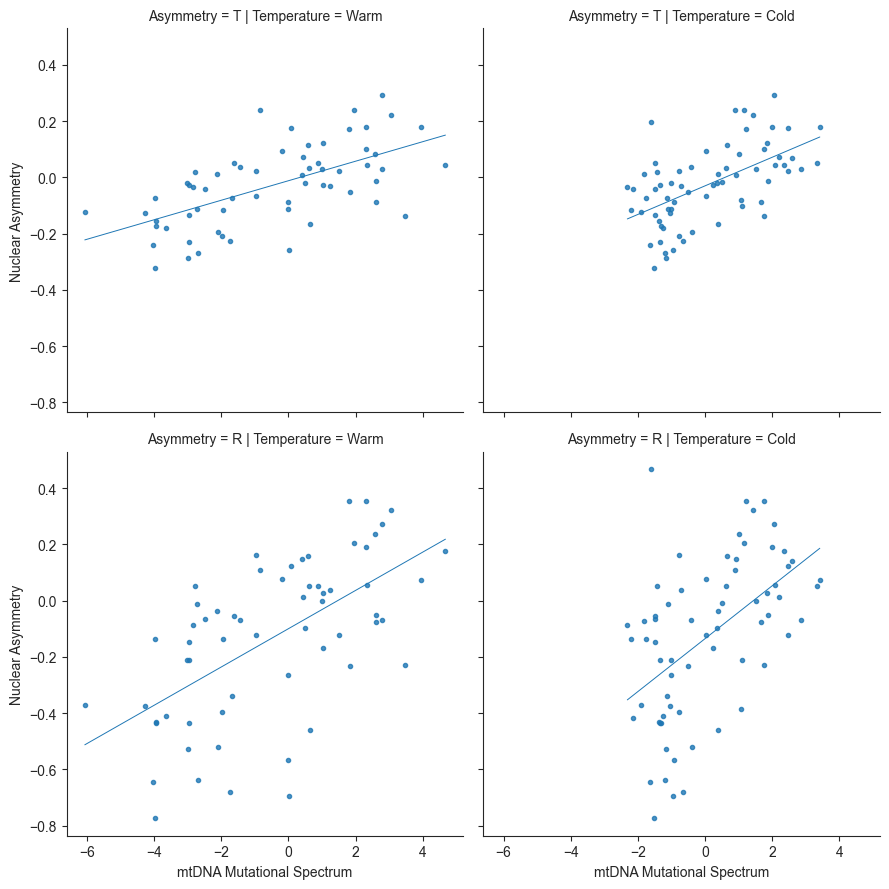

In [42]:
sns.lmplot(data=cold_warm.melt(["Mut", "Temperature", "mtDNA Mutational Spectrum"], ["T", "R"],
                                value_name="Nuclear Asymmetry", var_name="Asymmetry"),
                                x="mtDNA Mutational Spectrum", y="Nuclear Asymmetry", 
                                col="Temperature", row="Asymmetry", height=4.5, 
                                markers=".", ci=None, line_kws={"linewidth": 0.7})
#plt.savefig('../pictures/AsymmentryVSColdVSWarm.pdf', dpi=300)


In [43]:
warm_df = cold_warm[cold_warm.Temperature == 'Warm']
cold_df = cold_warm[cold_warm.Temperature == 'Cold']

In [44]:
cold_warm.head()

,AncestorCodon,MutBase,T,R,mtDNA Mutational Spectrum,Temperature,Mut
2,ACA,C>T,-0.012015,-0.052744,2.604617,Warm,A[C>T]A
5,ACC,C>T,0.028556,-0.069531,2.791319,Warm,A[C>T]C
8,ACG,C>T,0.071747,0.012317,0.434442,Warm,A[C>T]G
11,ACT,C>T,-0.088058,-0.074512,2.597737,Warm,A[C>T]T
13,ATA,T>C,-0.320754,-0.774055,-3.971254,Warm,A[T>C]A


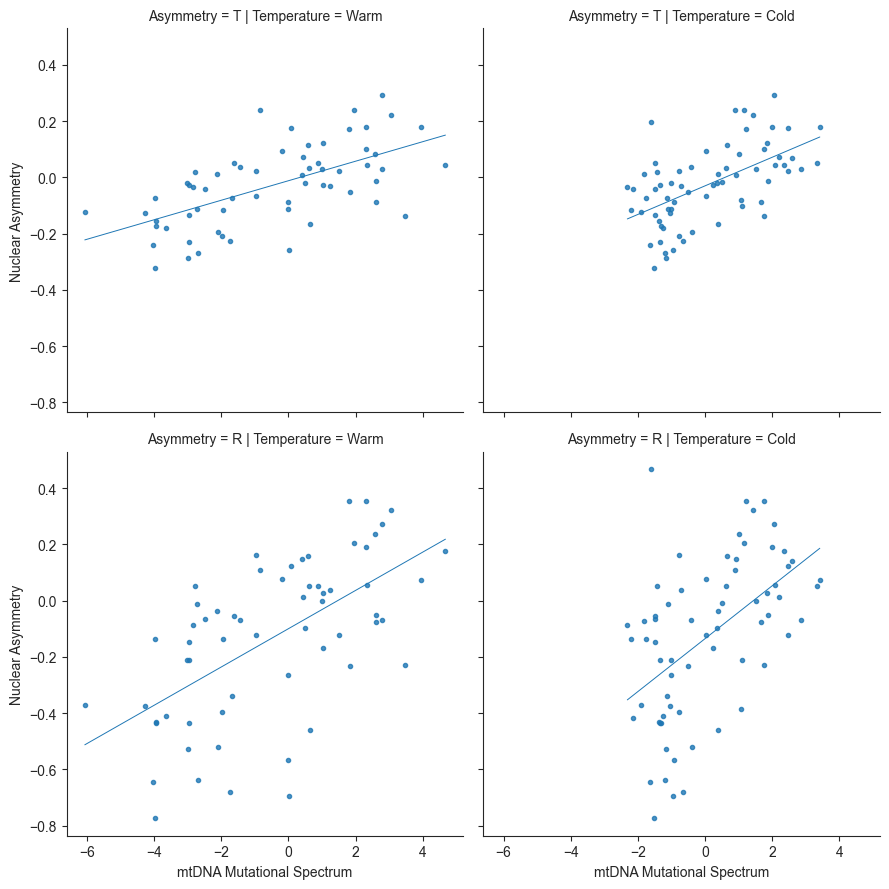

In [45]:
sns.lmplot(data=cold_warm.melt(["Mut", "Temperature", "mtDNA Mutational Spectrum"], ["T", "R"],
                                value_name="Nuclear Asymmetry", var_name="Asymmetry"),
                                x="mtDNA Mutational Spectrum", y="Nuclear Asymmetry", 
                                col="Temperature", row="Asymmetry", height=4.5, 
                                markers=".", ci=None, line_kws={"linewidth": 0.7})

In [46]:
T_warm = stats.spearmanr(warm_df['T'].values, warm_df['mtDNA Mutational Spectrum'].values, axis=0)
T_cold = stats.spearmanr(cold_df['T'].values, cold_df['mtDNA Mutational Spectrum'].values, axis=0)
R_warm = stats.spearmanr(warm_df['R'].values, warm_df['mtDNA Mutational Spectrum'].values, axis=0)
R_cold = stats.spearmanr(cold_df['R'].values, cold_df['mtDNA Mutational Spectrum'].values, axis=0)

# Who has greater assymmetry?

In [94]:
check_ass_gr = cold_warm.pivot(index='Mut', columns='Temperature', values='mtDNA Mutational Spectrum').reset_index()
check_ass_gr['MutBase'] = check_ass_gr.Mut.str.slice(2, 5)
check_ass_gr.head()

Temperature,Mut,Cold,Warm,MutBase
0,A[C>T]A,1.863106,2.604617,C>T
1,A[C>T]C,2.848228,2.791319,C>T
2,A[C>T]G,2.212966,0.434442,C>T
3,A[C>T]T,1.667049,2.597737,C>T
4,A[T>C]A,-1.517331,-3.971254,T>C


In [95]:
check_ass_gr_test = check_ass_gr.dropna()
stats.mannwhitneyu(abs(check_ass_gr_test.Cold), abs(check_ass_gr_test.Warm), alternative='two-sided')

MannwhitneyuResult(statistic=1189.0, pvalue=0.0005907449341102154)

It means that birds are more asyymetrical than fishes. Supercool!


In [96]:
check_ass_gr.head()

Temperature,Mut,Cold,Warm,MutBase
0,A[C>T]A,1.863106,2.604617,C>T
1,A[C>T]C,2.848228,2.791319,C>T
2,A[C>T]G,2.212966,0.434442,C>T
3,A[C>T]T,1.667049,2.597737,C>T
4,A[T>C]A,-1.517331,-3.971254,T>C


Text(0, 0.5, 'log2[mtDNA Mutational Spectrum Asymmetry of Warm Vertebrates]')

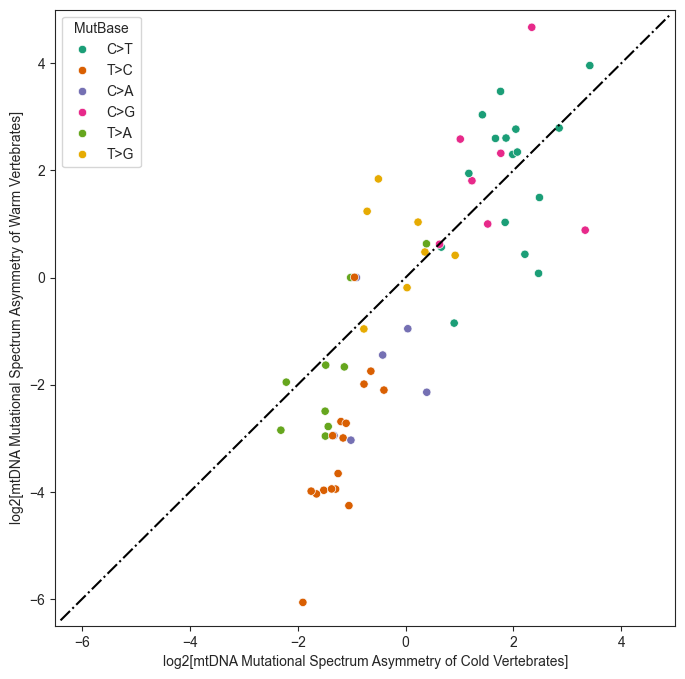

In [53]:
plt.figure(figsize=(8,8))
sns.scatterplot(data=check_ass_gr, x='Cold', y='Warm', hue='MutBase', palette='Dark2')
plt.xlim(-6.5, 5)
plt.ylim(-6.5, 5)
plt.plot([-6.4, 4.9], [-6.4, 4.9], color='black', linestyle='dashdot')
plt.xlabel('log2[mtDNA Mutational Spectrum Asymmetry of Cold Vertebrates]')
plt.ylabel('log2[mtDNA Mutational Spectrum Asymmetry of Warm Vertebrates]')
#plt.savefig('../pictures/cold_and_warm_comparison.pdf', dpi=300)

In [54]:
box_check_assym_temp = check_ass_gr.melt(["Mut", "MutBase"], 
                                  ['Cold', 'Warm'], 
                                  var_name="Temperature", value_name='mtDNA Mutational Spectrum')

box_check_assym_temp.head()

,Mut,MutBase,Temperature,mtDNA Mutational Spectrum
0,A[C>T]A,C>T,Cold,1.863106
1,A[C>T]C,C>T,Cold,2.848228
2,A[C>T]G,C>T,Cold,2.212966
3,A[C>T]T,C>T,Cold,1.667049
4,A[T>C]A,T>C,Cold,-1.517331


In [56]:
vailin_temp = box_check_assym_temp.pivot(index=['Mut', 'MutBase'], columns='Temperature', values='mtDNA Mutational Spectrum').reset_index()
vailin_temp['mtDNA Mutational Spectrum'] = abs(vailin_temp['Warm'] / vailin_temp['Cold'])
vailin_temp['Type'] = 'ColdvsWarm'
vailin_temp = vailin_temp.drop(['Cold', 'Warm'], axis=1)
vailin_temp.head()

Temperature,Mut,MutBase,mtDNA Mutational Spectrum,Type
0,A[C>T]A,C>T,1.397998,ColdvsWarm
1,A[C>T]C,C>T,0.980019,ColdvsWarm
2,A[C>T]G,C>T,0.196316,ColdvsWarm
3,A[C>T]T,C>T,1.558285,ColdvsWarm
4,A[T>C]A,T>C,2.617264,ColdvsWarm


### Perform asymmetry analysis with TBSS

In [57]:
low_tbss = pd.read_csv('https://raw.githubusercontent.com/mitoclub/mtdnaMutSpecOfCancers/main/data/asymmetry/ms_low_tsss_all.csv')
high_tbss = pd.read_csv('https://raw.githubusercontent.com/mitoclub/mtdnaMutSpecOfCancers/main/data/asymmetry/ms_high_tsss_all.csv')

high_tbss.head()

,Mut,ObsNum,ExpNum,RawMutSpec,MutSpec
0,A[A>C]C,8,137,0.058394,0.001211
1,A[A>G]A,1,126,0.007937,0.000165
2,A[A>G]C,22,137,0.160584,0.003330
3,A[A>G]T,7,92,0.076087,0.001578
4,A[A>T]A,3,126,0.023810,0.000494


In [58]:
low_tbss['MutBase'] = low_tbss.Mut.str.slice(2,5)
low_tbss['AncestorCodon'] = low_tbss.Mut.str.get(0) + low_tbss.Mut.str.get(2) + low_tbss.Mut.str.get(-1)
high_tbss['MutBase'] = high_tbss.Mut.str.slice(2,5)
high_tbss['AncestorCodon'] = high_tbss.Mut.str.get(0) + high_tbss.Mut.str.get(2) + high_tbss.Mut.str.get(-1)
low_tbss.head()

,Mut,ObsNum,ExpNum,RawMutSpec,MutSpec,MutBase,AncestorCodon
0,A[A>C]C,1,118,0.008475,0.000258,A>C,AAC
1,A[A>C]T,1,110,0.009091,0.000277,A>C,AAT
2,A[A>G]A,4,118,0.033898,0.001033,A>G,AAA
3,A[A>G]C,14,118,0.118644,0.003616,A>G,AAC
4,A[A>G]G,4,43,0.093023,0.002835,A>G,AAG


Transform 196 comp mutational spectrum of TBSS to 96 component

In [59]:
low_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=low_tbss)
high_96_comp = transform192_to96(asymmetry_df=assymetry, df_transform=high_tbss)

/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_62453/1000977383.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_62453/1000977383.py:13: RuntimeWarning: invalid value encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_62453/1000977383.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/zp/hykk29rd2lndslkkjgkzfb640000gn/T/ipykernel_62453/1000977383.py:13: RuntimeWarning: invalid value encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec


In [60]:
low_96_comp = low_96_comp[low_96_comp.MutSpec != 0]
low_96_comp.MutSpec = np.log2(low_96_comp.MutSpec)
low_96_comp['TypeinCl'] = 'Low'

high_96_comp = high_96_comp[high_96_comp.MutSpec != 0]
high_96_comp.MutSpec = np.log2(high_96_comp.MutSpec)
high_96_comp['TypeinCl'] = 'High'

low_high = pd.concat([low_96_comp, high_96_comp])
low_high['Mut'] = low_high.AncestorCodon.str.get(0) + '[' + low_high.MutBase.str.get(0) + '>'  + low_high.MutBase.str.get(-1) + ']' + low_high.AncestorCodon.str.get(-1)
low_high = low_high.rename(columns={'MutSpec':'mtDNA Mutational Spectrum'})

low_high.head()


,AncestorCodon,MutBase,mtDNA Mutational Spectrum,TypeinCl,Mut
2,ACA,C>T,-4.050626,Low,A[C>T]A
5,ACC,C>T,-4.066089,Low,A[C>T]C
8,ACG,C>T,-3.832123,Low,A[C>T]G
11,ACT,C>T,-4.608809,Low,A[C>T]T
13,ATA,T>C,2.212142,Low,A[T>C]A


In [61]:
low_high = low_high.pivot(index=['Mut', 'MutBase'], columns='TypeinCl', values = 'mtDNA Mutational Spectrum').reset_index()
low_high['mtDNA Mutational Spectrum'] = abs(low_high['High'] / low_high['Low'])
low_high['Type'] = 'TBSS'
low_high = low_high.drop(['High', 'Low'], axis=1)
low_high = low_high.dropna()
low_high.head()

TypeinCl,Mut,MutBase,mtDNA Mutational Spectrum,Type
0,A[C>T]A,C>T,0.897270,TBSS
1,A[C>T]C,C>T,0.862198,TBSS
3,A[C>T]T,C>T,1.041258,TBSS
5,A[T>C]A,T>C,1.415806,TBSS
6,A[T>C]C,T>C,1.109664,TBSS


In [62]:
violin_all = pd.concat([vailin_temp, low_high]).reset_index().drop('index', axis=1)
violin_all.head()

,Mut,MutBase,mtDNA Mutational Spectrum,Type
0,A[C>T]A,C>T,1.397998,ColdvsWarm
1,A[C>T]C,C>T,0.980019,ColdvsWarm
2,A[C>T]G,C>T,0.196316,ColdvsWarm
3,A[C>T]T,C>T,1.558285,ColdvsWarm
4,A[T>C]A,T>C,2.617264,ColdvsWarm


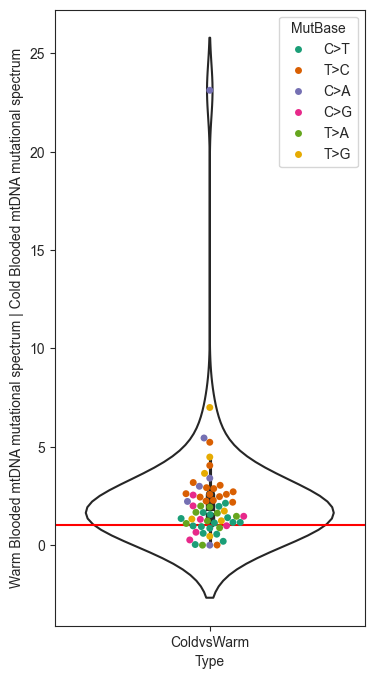

In [112]:
plt.figure(figsize=(4,8))
sns.violinplot(data=violin_all[violin_all.Type == 'ColdvsWarm'], x='Type', y='mtDNA Mutational Spectrum', fill=False, palette='dark:black', hue='Type', native_scale=True)
sns.swarmplot(data=violin_all[violin_all.Type == 'ColdvsWarm'], x='Type', y='mtDNA Mutational Spectrum', hue='MutBase', palette='Dark2')
plt.axhline(1.0, color='red')
plt.ylabel('Warm Blooded mtDNA mutational spectrum | Cold Blooded mtDNA mutational spectrum')
plt.savefig('../pictures/ColdvsWarmViolin.pdf', dpi=300)

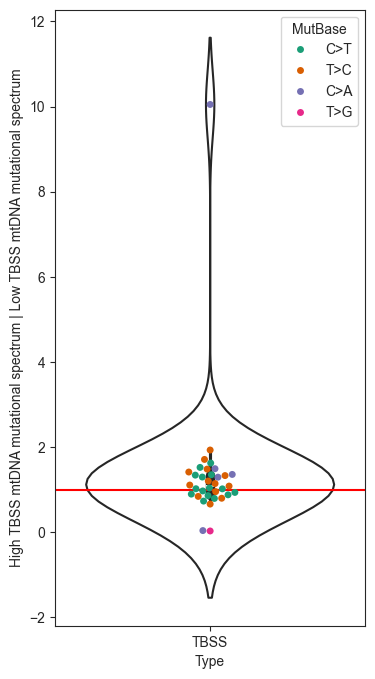

In [111]:
plt.figure(figsize=(4,8))
sns.violinplot(data=violin_all[violin_all.Type == 'TBSS'], x='Type', y='mtDNA Mutational Spectrum', fill=False, palette='dark:black', hue='Type', native_scale=True)
sns.swarmplot(data=violin_all[violin_all.Type == 'TBSS'], x='Type', y='mtDNA Mutational Spectrum', hue='MutBase', palette='Dark2')
plt.axhline(1.0, color='red')
plt.ylabel('High TBSS mtDNA mutational spectrum | Low TBSS mtDNA mutational spectrum')
plt.savefig('../pictures/TBSSViolin.pdf', dpi=300)

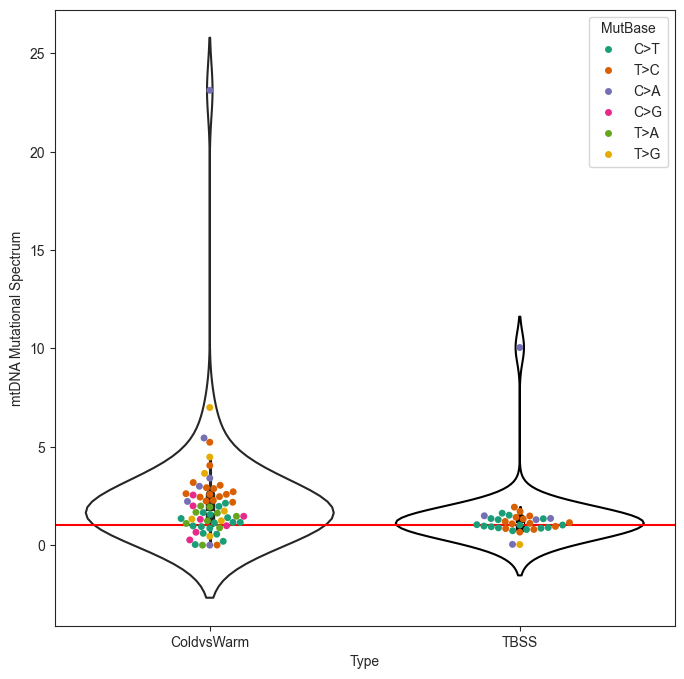

In [63]:
plt.figure(figsize=(8,8))
sns.violinplot(data=violin_all, x='Type', y='mtDNA Mutational Spectrum', fill=False, palette='dark:black', hue='Type', native_scale=True)
sns.swarmplot(data=violin_all, x='Type', y='mtDNA Mutational Spectrum', hue='MutBase', palette='Dark2')
plt.axhline(1.0, color='red')
#plt.savefig('../pictures/TBSS_and_Temperature.pdf', dpi=300)

### Comparison '1' with TBSS and WarmVSCold asymmetry ratio 

In [117]:
to_stat = violin_all.dropna()

In [102]:
stats.wilcoxon(to_stat[to_stat.Type == 'ColdvsWarm']['mtDNA Mutational Spectrum'] - 1, alternative='two-sided')

WilcoxonResult(statistic=277.0, pvalue=1.573234693533582e-06)

In [115]:
print(f'Number of Mutations in WormVSCold: {len(to_stat[to_stat.Type == "ColdvsWarm"]["mtDNA Mutational Spectrum"])}')

Number of Mutations in WormVSCold: 61


In [103]:
stats.wilcoxon(to_stat[to_stat.Type == 'TBSS']['mtDNA Mutational Spectrum'] - 1, alternative='two-sided')

WilcoxonResult(statistic=189.0, pvalue=0.06433000124525279)

In [116]:
print(f'Number of Mutations in HighTBSS vs Low TBSS: {len(to_stat[to_stat.Type == "TBSS"]["mtDNA Mutational Spectrum"])}')

Number of Mutations in HighTBSS vs Low TBSS: 34
